<a href="https://colab.research.google.com/github/Masterjun12/RL/blob/main/actorcritic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

라이브러리 임포트

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import gym
from torch import optim

### 크리틱 클래스

벨류값을 반환

In [ ]:
# Critic 신경망
class Critic(nn.Module):
    def __init__(self, state_dim, hidden_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, 1) # 벨류값

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

### 액터 클래스

평균과 표준편차를 이용하여 연속적인 액션을취함

In [ ]:
# Actor 신경망
class Actor(nn.Module):
    def __init__(self, state_dim, hidden_size, action_dim):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_dim, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc_mu = nn.Linear(hidden_size, action_dim)
        self.fc_std = nn.Linear(hidden_size, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        mu = self.fc_mu(x)
        std = F.softplus(self.fc_std(x)) #  행동의 표준편차를 계산
        return mu, std

### 액터크리틱 클래스

액션을 선택 하고 TD 타겟에 맞춰 액터와 크리틱 둘다 업데이트

In [ ]:
# Actor-Critic 에이전트
class ActorCriticAgent:
    def __init__(self, state_dim, hidden_size, action_dim, actor_lr, critic_lr, gamma):
        self.actor = Actor(state_dim, hidden_size, action_dim)
        self.critic = Critic(state_dim, hidden_size)
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=actor_lr)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=critic_lr)
        self.gamma = gamma

    def select_action(self, state):
        state = torch.FloatTensor(state)
        mu, std = self.actor(state)
        dist = torch.distributions.Normal(mu, std)
        action = dist.sample()
        return action.detach().numpy()


    def update(self, state, action, reward, next_state, done):
        state = torch.FloatTensor(state)
        next_state = torch.FloatTensor(next_state)
        action = torch.FloatTensor(action)
        reward = torch.FloatTensor([reward])
        done = torch.FloatTensor([done])
        # 현재 상태의 가치와 다음 상태의 가치 계산
        value = self.critic(state)
        next_value = self.critic(next_state)

        # TD 타깃 계산
        target = reward + self.gamma * next_value * (1 - done)
        td_error = target - value

        # Critic 신경망 업데이트
        critic_loss = td_error.pow(2).mean()
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        # Actor 신경망 업데이트
        mu, std = self.actor(state)
        dist = torch.distributions.Normal(mu, std)
        log_prob = dist.log_prob(action).sum(-1, keepdim=True)
        actor_loss = -(log_prob * td_error.detach()).mean()  # 어센트
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

환경설정 및 하이퍼파라미터

In [ ]:
env_name = 'Pendulum-v1'
agent_name = 'Actorcritic2'

In [ ]:
# 환경 및 하이퍼파라미터 설정
env = gym.make(env_name)
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.shape[0]
hidden_size = 64
actor_lr = 1e-4
critic_lr = 1e-3
gamma = 0.99
num_episodes = 10000

/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


시각화용 필수 라이브러리 설치

In [ ]:
!pip install wandb
!apt-get install x11-utils
!pip install pyglet
!apt-get install -y xvfb python-opengl

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
x11-utils is already the newest version (7.7+5build2).
0 upgraded, 0 newly installed, 0 to remove and 9 not upgraded.
Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
E: Unable to locate package python-opengl


wandb 초기화

In [ ]:
import gym
import wandb

wandb.init(project=env_name, group=agent_name)

/usr/local/lib/python3.10/dist-packages/notebook/utils.py:280: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  return LooseVersion(v) >= LooseVersion(check)
wandb: Currently logged in as: oylim982. Use `wandb login --relogin` to force relogin


main 함수 이터레이션만큼 학습반복

In [ ]:
# 학습 루프
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0

    agent = ActorCriticAgent(state_dim, hidden_size, action_dim, actor_lr, critic_lr, gamma)

    while not done:
        action = agent.select_action(state)  #s에서 액션선택
        next_state, reward, done, _ = env.step(action) # 받을 값 받고, 종료여부
        agent.update(state, action, reward, next_state, done) # 에이전트를 업데이트

        episode_reward += reward  # 보상 누적
        state = next_state

    wandb.log({'Episode': episode, 'Cumulative Reward': episode_reward})

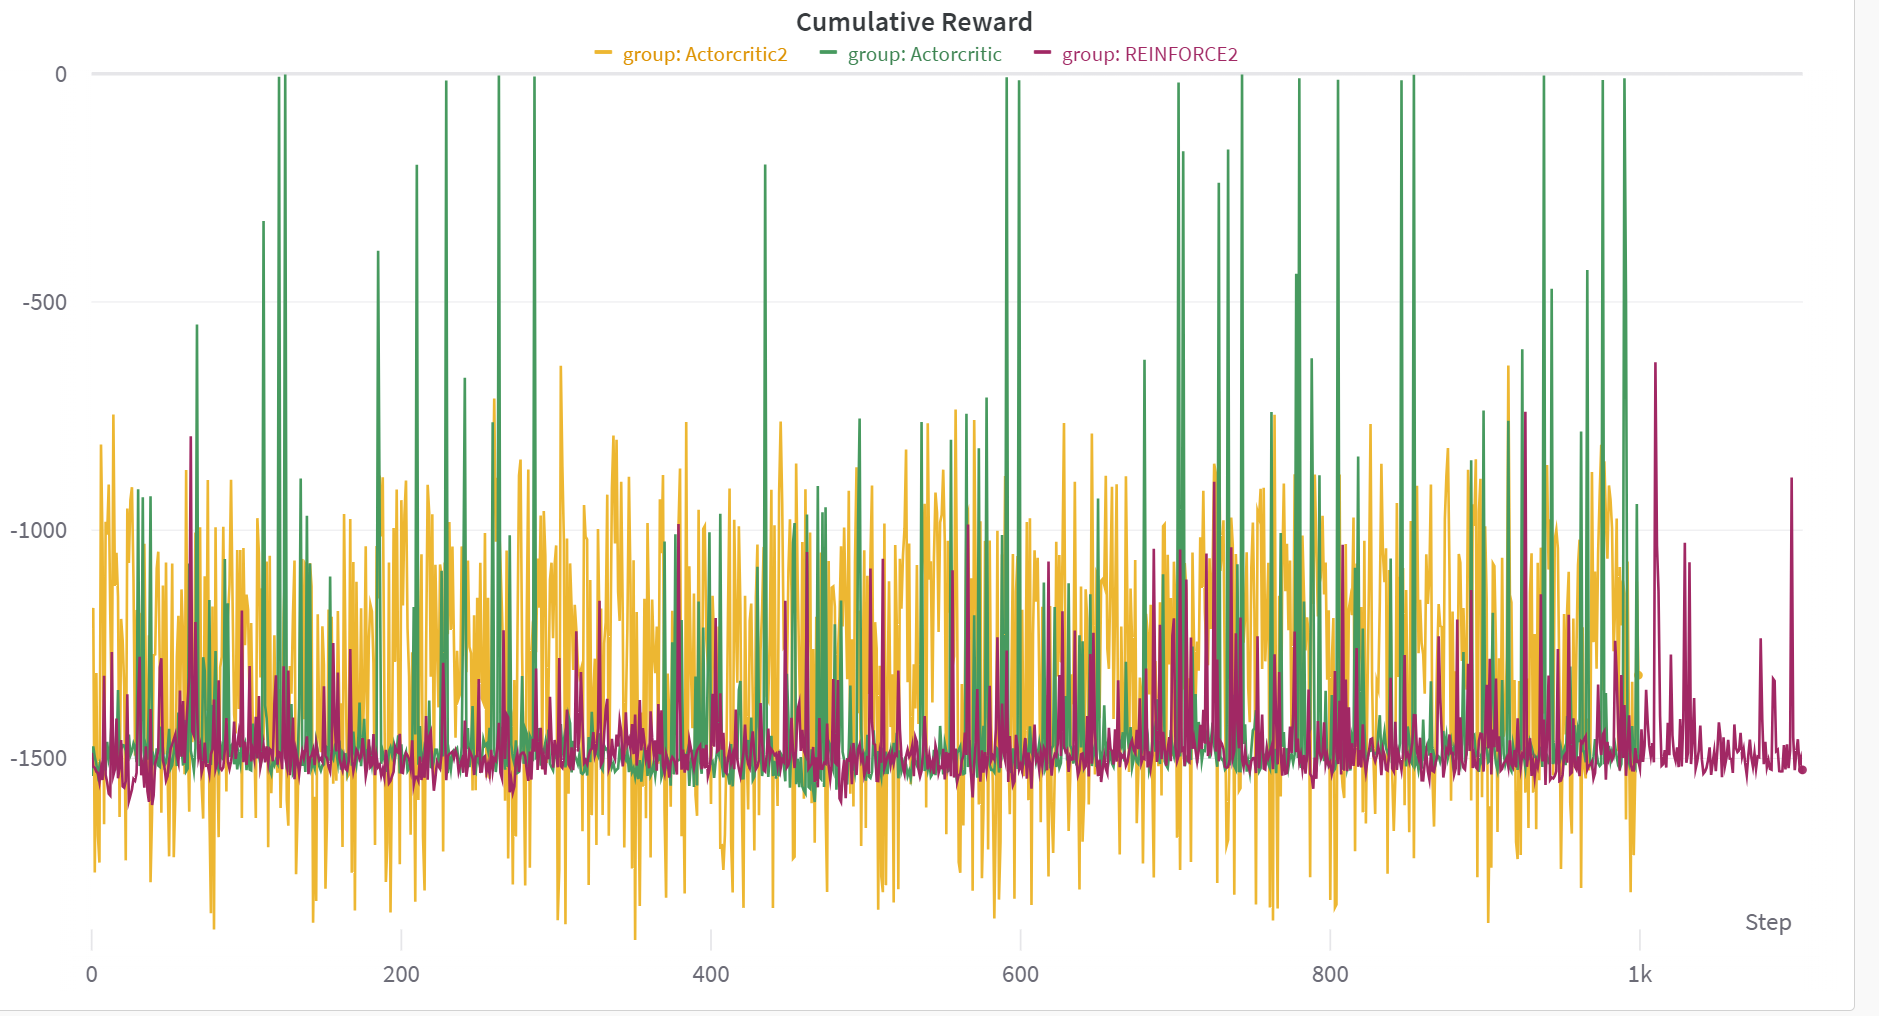

시각화 및 비디오저장

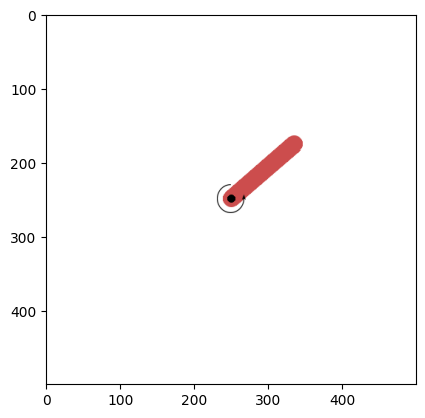

In [ ]:
import gym
import matplotlib.pyplot as plt
import pygame
from IPython import display as ipythondisplay
from IPython.lib.pretty import Breakable
import imageio

env.reset()
pygame.init()

prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)


frames = [] # 저장될 프레임

# 메인루프
for episode in range(num_episodes):
    state = env.reset()
    done = False
    episode_reward = 0
    agent = ActorCriticAgent(state_dim, hidden_size, action_dim, actor_lr, critic_lr, gamma)

    while not done:
        action = agent.select_action(state)
        next_state, reward, done, _ = env.step(action)
        agent.update(state, action, reward, next_state, done)

        episode_reward += reward  # 보상 누적
        state = next_state

        # 화면 렌더링 및 프레임 저장
        frame = env.render(mode='rgb_array')
        frames.append(frame)
        plt.imshow(frame)
        ipythondisplay.clear_output(wait=True)
        ipythondisplay.display(plt.gcf())

        if done:
            s, done, ret = env.reset(), False, 0

    wandb.log({'Episode': episode, 'Cumulative Reward': episode_reward})
    print(episode)

env.close()

imageio.mimsave('gym_animation.mp4', frames, fps=20)